In [ ]:

%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import defaultdict
import math as mat
from matplotlib import cm
import scipy as sp
from astropy.cosmology import FlatLambdaCDM,WMAP5,WMAP7,WMAP9,Planck13,Planck15
from astropy import units as u
from astropy.units import cds
import matplotlib.pyplot as plt
import astropy.constants as cc
from scipy.special import zeta
from scipy.optimize import newton
from scipy.integrate import simps
from numpy import sqrt,pi,exp

colums = ['source_id','ra','dec','PLX','T']

data = pd.read_csv('1673643478664O-result.csv', skiprows=1 ,names= colums)

Distance_table = abs(1/(data['PLX'] * 0.001))

x = Distance_table * np.cos(data['ra']) * np.sin(data['dec'])
y = Distance_table * np.sin(data['ra']) * np.sin(data['dec'])
z = Distance_table * np.cos(data['dec'])

Wavelength = 0.0029/(data["T"]) * 10**9


# def wavelength_to_rgb(wavelength):

#     '''This converts a given wavelength of light to an 
#     approximate RGB color value. The wavelength must be given
#     in nanometers in the range from 380 nm through 750 nm
#     (789 THz through 400 THz).
#     Based on code by Dan Bruton
#     http://www.physics.sfasu.edu/astro/color/spectra.html
#     '''

#     wavelength = wavelength
#     if np.logical_and((wavelength >= 380),(wavelength <= 440)):
#         attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
#         R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** 0.8
#         G = 0.0
#         B = (1.0 * attenuation) ** 0.8
#     elif np.logical_and((wavelength >= 440), (wavelength <= 490)):
#         R = 0.0
#         G = ((wavelength - 440) / (490 - 440)) ** 0.8
#         B = 1.0
#     elif np.logical_and((wavelength >= 490),(wavelength <= 510)):
#         R = 0.0
#         G = 1.0
#         B = (-(wavelength - 510) / (510 - 490)) ** 0.8
#     elif np.logical_and((wavelength >= 510),(wavelength <= 580)):
#         R = ((wavelength - 510) / (580 - 510)) ** 0.8
#         G = 1.0
#         B = 0.0
#     elif np.logical_and((wavelength >= 580) ,(wavelength <= 645)):
#         R = 1.0
#         G = (-(wavelength - 645) / (645 - 580)) ** 0.8
#         B = 0.0
#     elif np.logical_and((wavelength >= 645) , (wavelength <= 750)):
#         attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
#         R = (1.0 * attenuation) ** 0.8
#         G = 0.0
#         B = 0.0
#     else:
#         R = 0.0
#         G = 0.0
#         B = 0.0

#     return (R, G, B)


def rgb(lam,spec,std=False,ncol=1,showit=False):
    """
    Return RGB color of a spectrum.
    Keywords
    --------
    lam:        Wavelength in nm
    spec:       Radiance, or intensity, or brightness, or luminosity, or
                whatever quantity with units that are sorta kinda
                energy/s/sterad/cm2/wavelength. Normalization doesn't matter.
    ncol:       Normalization constant, e.g. set ncol=255 for color range [0-255]
    """
    x,y = xy(lam,spec)
    z   = 1 - x - y
    Y   = 1.
    X   = (Y/y) * x
    Z   = (Y/y) * z
    XYZ = np.array([X,Y,Z])

    # Matrix for Wide RGB D65 conversion
    if std:
        XYZ2RGB = np.array([[ 3.2406, -1.5372, -0.4986],
                            [-0.9689,  1.8758,  0.0415],
                            [ 0.0557, -0.2040,  1.0570]])
    else:
        XYZ2RGB = np.array([[ 1.656492, -0.354851, -0.255038],
                            [-0.707196,  1.655397,  0.036152],
                            [ 0.051713, -0.121364,  1.011530]])

    RGB = np.dot(XYZ2RGB,XYZ)                   #Map XYZ to RGB
    RGB = adjust_gamma(RGB)                     #Adjust gamma
  # RGB = RGB / np.array([0.9505, 1., 1.0890])  #Scale so that Y of "white" (D65) is (0.9505, 1.0000, 1.0890)
    maxRGB = max(RGB.flatten())
    if maxRGB > 1: RGB = RGB / maxRGB           #Normalize to 1 if there are values above
    RGB = RGB.clip(min=0)                       #Clip negative values

    if showit:
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches
        plt.close('all')
        fig,ax = plt.subplots(figsize=plt.figaspect(1))
      # wm = plt.get_current_fig_manager()
      # wm.window.wm_geometry('100x100+700+550')
        ax.set_xticks([])
        ax.set_xticklabels('')
        ax.set_yticks([])
        ax.set_yticklabels('')
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        rgba = [RGB[0], RGB[1], RGB[2], 1.]
        rect = patches.Rectangle((0,0),1,1, edgecolor='none',facecolor=rgba)
        ax.add_patch(rect)
        plt.tight_layout()
        plt.draw()
        plt.show()
        input("Hit Enter to quit")
        plt.close()


    RGB = ncol * RGB                            #Normalize to number of colors

    return RGB

def xy(lam,L):
    """
    Return x,y position in CIE 1931 color space chromaticity diagram for an
    arbitrary spectrum.
    Keywords
    -------
    lam:    Wavelength in nm
    L:      Spectral radiance
    """
    lamcie,xbar,ybar,zbar = cie()               #Color matching functions
    L = np.interp(lamcie,lam,L)                 #Interpolate to same axis

    #Tristimulus values
    X = simps(L*xbar,lamcie)
    Y = simps(L*ybar,lamcie)
    Z = simps(L*zbar,lamcie)
    XYZ = np.array([X,Y,Z])
    x = X / sum(XYZ)
    y = Y / sum(XYZ)
    z = Z / sum(XYZ)
    return x,y

def planck(lam, T):
    """
    Spectral radiance of a blackbody of temperature T.
    Keywords
    -------
    lam     Wavelength in nm
    T       Temperature in K
    Returns
    -------
    Spectral radiance in cgs units (erg/s/sr/cm2)
    """
    lam = lam * u.nm
    x   = cc.h * cc.c / lam / cc.k_B / (T*u.K)
    B   = 2*cc.h*cc.c**2 / lam**5 / (exp(x) - 1)
    return B.cgs.value

def rgb_from_T(T,std=False,ncol=1,showit=False):
    """
    Calculate RGB color of a Planck spectrum of temperature T.
    See rgb.__doc__ for a description of keywords.
    """
    lam = np.linspace(350,800,100)
    B   = planck(lam,T)

    if showit:
        RGB = rgb(lam,B,std=std,ncol=1,showit=True)
    else:
        if T < 670:
            RGB = np.array([1,0,0])
        elif 670 <= T < 675:
            RGB = rgb(lam,B,std=std,ncol=1,showit=False)
            RGB[2] = 0
        elif 675 <= T < 1e7:
            RGB = rgb(lam,B,std=std,ncol=1,showit=False)
        else:
            RGB = np.array([0.63130101, 0.71233531, 1.])

    return ncol * RGB

def cie():
    """
    Color matching functions. Columns are wavelength in nm, and xbar, ybar,
    and zbar, are the functions for R, G, and B, respectively.
    """
    lxyz = np.array([[380., 0.0014, 0.0000, 0.0065],
                     [385., 0.0022, 0.0001, 0.0105],
                     [390., 0.0042, 0.0001, 0.0201],
                     [395., 0.0076, 0.0002, 0.0362],
                     [400., 0.0143, 0.0004, 0.0679],
                     [405., 0.0232, 0.0006, 0.1102],
                     [410., 0.0435, 0.0012, 0.2074],
                     [415., 0.0776, 0.0022, 0.3713],
                     [420., 0.1344, 0.0040, 0.6456],
                     [425., 0.2148, 0.0073, 1.0391],
                     [430., 0.2839, 0.0116, 1.3856],
                     [435., 0.3285, 0.0168, 1.6230],
                     [440., 0.3483, 0.0230, 1.7471],
                     [445., 0.3481, 0.0298, 1.7826],
                     [450., 0.3362, 0.0380, 1.7721],
                     [455., 0.3187, 0.0480, 1.7441],
                     [460., 0.2908, 0.0600, 1.6692],
                     [465., 0.2511, 0.0739, 1.5281],
                     [470., 0.1954, 0.0910, 1.2876],
                     [475., 0.1421, 0.1126, 1.0419],
                     [480., 0.0956, 0.1390, 0.8130],
                     [485., 0.0580, 0.1693, 0.6162],
                     [490., 0.0320, 0.2080, 0.4652],
                     [495., 0.0147, 0.2586, 0.3533],
                     [500., 0.0049, 0.3230, 0.2720],
                     [505., 0.0024, 0.4073, 0.2123],
                     [510., 0.0093, 0.5030, 0.1582],
                     [515., 0.0291, 0.6082, 0.1117],
                     [520., 0.0633, 0.7100, 0.0782],
                     [525., 0.1096, 0.7932, 0.0573],
                     [530., 0.1655, 0.8620, 0.0422],
                     [535., 0.2257, 0.9149, 0.0298],
                     [540., 0.2904, 0.9540, 0.0203],
                     [545., 0.3597, 0.9803, 0.0134],
                     [550., 0.4334, 0.9950, 0.0087],
                     [555., 0.5121, 1.0000, 0.0057],
                     [560., 0.5945, 0.9950, 0.0039],
                     [565., 0.6784, 0.9786, 0.0027],
                     [570., 0.7621, 0.9520, 0.0021],
                     [575., 0.8425, 0.9154, 0.0018],
                     [580., 0.9163, 0.8700, 0.0017],
                     [585., 0.9786, 0.8163, 0.0014],
                     [590., 1.0263, 0.7570, 0.0011],
                     [595., 1.0567, 0.6949, 0.0010],
                     [600., 1.0622, 0.6310, 0.0008],
                     [605., 1.0456, 0.5668, 0.0006],
                     [610., 1.0026, 0.5030, 0.0003],
                     [615., 0.9384, 0.4412, 0.0002],
                     [620., 0.8544, 0.3810, 0.0002],
                     [625., 0.7514, 0.3210, 0.0001],
                     [630., 0.6424, 0.2650, 0.0000],
                     [635., 0.5419, 0.2170, 0.0000],
                     [640., 0.4479, 0.1750, 0.0000],
                     [645., 0.3608, 0.1382, 0.0000],
                     [650., 0.2835, 0.1070, 0.0000],
                     [655., 0.2187, 0.0816, 0.0000],
                     [660., 0.1649, 0.0610, 0.0000],
                     [665., 0.1212, 0.0446, 0.0000],
                     [670., 0.0874, 0.0320, 0.0000],
                     [675., 0.0636, 0.0232, 0.0000],
                     [680., 0.0468, 0.0170, 0.0000],
                     [685., 0.0329, 0.0119, 0.0000],
                     [690., 0.0227, 0.0082, 0.0000],
                     [695., 0.0158, 0.0057, 0.0000],
                     [700., 0.0114, 0.0041, 0.0000],
                     [705., 0.0081, 0.0029, 0.0000],
                     [710., 0.0058, 0.0021, 0.0000],
                     [715., 0.0041, 0.0015, 0.0000],
                     [720., 0.0029, 0.0010, 0.0000],
                     [725., 0.0020, 0.0007, 0.0000],
                     [730., 0.0014, 0.0005, 0.0000],
                     [735., 0.0010, 0.0004, 0.0000],
                     [740., 0.0007, 0.0002, 0.0000],
                     [745., 0.0005, 0.0002, 0.0000],
                     [750., 0.0003, 0.0001, 0.0000],
                     [755., 0.0002, 0.0001, 0.0000],
                     [760., 0.0002, 0.0001, 0.0000],
                     [765., 0.0001, 0.0000, 0.0000],
                     [770., 0.0001, 0.0000, 0.0000],
                     [775., 0.0001, 0.0000, 0.0000],
                     [780., 0.0000, 0.0000, 0.0000]])
    return lxyz.T
def adjust_gamma(RGB):
    """
    Adjust gamma value of RGB color
    """
    a = 0.055
    for i,color in enumerate(RGB):
        if color <= 0.0031308:
            RGB[i] = 12.92 * color
        else:
            RGB[i] = (1+a) * color**(1/2.4) - a
    return RGB

RGBA = []
for Temp in data["T"]:
    RGBA.append(rgb_from_T(Temp))

user_input= input("Which star would you like to highlight ('None' for no highlight):")

if user_input == 'None':

    fig = plt.figure()
    plt.figure(figsize=(10,10))
    plt.style.context('dark_background')
    ax = plt.axes(projection='3d')
    ax.scatter3D(x, y, z, c=RGBA, alpha=0.2, marker='.')
    ax.w_xaxis.set_pane_color((0, 0, 0, 1.0)) 
    ax.w_yaxis.set_pane_color((0, 0, 0, 1.0)) 
    ax.w_zaxis.set_pane_color((0, 0, 0, 1.0)) 
    ax.scatter3D(0, 0, 0, c='Blue', alpha=1)


plt.show()

#10 Parralax marcs 100pc

In [ ]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import defaultdict
import math as mat
from matplotlib import cm
import scipy as sp
from astropy.cosmology import FlatLambdaCDM,WMAP5,WMAP7,WMAP9,Planck13,Planck15
from astropy import units as u
from astropy.units import cds
import matplotlib.pyplot as plt
import astropy.constants as cc
from scipy.special import zeta
from scipy.optimize import newton
from scipy.integrate import simps
from numpy import sqrt,pi,exp

colums = ['source_id','ra','dec','PLX','T']

data = pd.read_csv('1673643095055O-result.csv', skiprows=1 ,names= colums)

Distance_table = abs(1/(data['PLX'] * 0.001))

x = Distance_table * np.cos(data['ra']) * np.sin(data['dec'])
y = Distance_table * np.sin(data['ra']) * np.sin(data['dec'])
z = Distance_table * np.cos(data['dec'])

Wavelength = 0.0029/(data["T"]) * 10**9


def rgb(lam,spec,std=False,ncol=1,showit=False):
    """
    Return RGB color of a spectrum.
    Keywords
    --------
    lam:        Wavelength in nm
    spec:       Radiance, or intensity, or brightness, or luminosity, or
                whatever quantity with units that are sorta kinda
                energy/s/sterad/cm2/wavelength. Normalization doesn't matter.
    ncol:       Normalization constant, e.g. set ncol=255 for color range [0-255]
    """
    x,y = xy(lam,spec)
    z   = 1 - x - y
    Y   = 1.
    X   = (Y/y) * x
    Z   = (Y/y) * z
    XYZ = np.array([X,Y,Z])

    # Matrix for Wide RGB D65 conversion
    if std:
        XYZ2RGB = np.array([[ 3.2406, -1.5372, -0.4986],
                            [-0.9689,  1.8758,  0.0415],
                            [ 0.0557, -0.2040,  1.0570]])
    else:
        XYZ2RGB = np.array([[ 1.656492, -0.354851, -0.255038],
                            [-0.707196,  1.655397,  0.036152],
                            [ 0.051713, -0.121364,  1.011530]])

    RGB = np.dot(XYZ2RGB,XYZ)                   #Map XYZ to RGB
    RGB = adjust_gamma(RGB)                     #Adjust gamma
  # RGB = RGB / np.array([0.9505, 1., 1.0890])  #Scale so that Y of "white" (D65) is (0.9505, 1.0000, 1.0890)
    maxRGB = max(RGB.flatten())
    if maxRGB > 1: RGB = RGB / maxRGB           #Normalize to 1 if there are values above
    RGB = RGB.clip(min=0)                       #Clip negative values

    if showit:
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches
        plt.close('all')
        fig,ax = plt.subplots(figsize=plt.figaspect(1))
      # wm = plt.get_current_fig_manager()
      # wm.window.wm_geometry('100x100+700+550')
        ax.set_xticks([])
        ax.set_xticklabels('')
        ax.set_yticks([])
        ax.set_yticklabels('')
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        rgba = [RGB[0], RGB[1], RGB[2], 1.]
        rect = patches.Rectangle((0,0),1,1, edgecolor='none',facecolor=rgba)
        ax.add_patch(rect)
        plt.tight_layout()
        plt.draw()
        plt.show()
        input("Hit Enter to quit")
        plt.close()


    RGB = ncol * RGB                            #Normalize to number of colors

    return RGB

def xy(lam,L):
    """
    Return x,y position in CIE 1931 color space chromaticity diagram for an
    arbitrary spectrum.
    Keywords
    -------
    lam:    Wavelength in nm
    L:      Spectral radiance
    """
    lamcie,xbar,ybar,zbar = cie()               #Color matching functions
    L = np.interp(lamcie,lam,L)                 #Interpolate to same axis

    #Tristimulus values
    X = simps(L*xbar,lamcie)
    Y = simps(L*ybar,lamcie)
    Z = simps(L*zbar,lamcie)
    XYZ = np.array([X,Y,Z])
    x = X / sum(XYZ)
    y = Y / sum(XYZ)
    z = Z / sum(XYZ)
    return x,y

def planck(lam, T):
    """
    Spectral radiance of a blackbody of temperature T.
    Keywords
    -------
    lam     Wavelength in nm
    T       Temperature in K
    Returns
    -------
    Spectral radiance in cgs units (erg/s/sr/cm2)
    """
    lam = lam * u.nm
    x   = cc.h * cc.c / lam / cc.k_B / (T*u.K)
    B   = 2*cc.h*cc.c**2 / lam**5 / (exp(x) - 1)
    return B.cgs.value

def rgb_from_T(T,std=False,ncol=1,showit=False):
    """
    Calculate RGB color of a Planck spectrum of temperature T.
    See rgb.__doc__ for a description of keywords.
    """
    lam = np.linspace(350,800,100)
    B   = planck(lam,T)

    if showit:
        RGB = rgb(lam,B,std=std,ncol=1,showit=True)
    else:
        if T < 670:
            RGB = np.array([1,0,0])
        elif 670 <= T < 675:
            RGB = rgb(lam,B,std=std,ncol=1,showit=False)
            RGB[2] = 0
        elif 675 <= T < 1e7:
            RGB = rgb(lam,B,std=std,ncol=1,showit=False)
        else:
            RGB = np.array([0.63130101, 0.71233531, 1.])

    return ncol * RGB

def cie():
    """
    Color matching functions. Columns are wavelength in nm, and xbar, ybar,
    and zbar, are the functions for R, G, and B, respectively.
    """
    lxyz = np.array([[380., 0.0014, 0.0000, 0.0065],
                     [385., 0.0022, 0.0001, 0.0105],
                     [390., 0.0042, 0.0001, 0.0201],
                     [395., 0.0076, 0.0002, 0.0362],
                     [400., 0.0143, 0.0004, 0.0679],
                     [405., 0.0232, 0.0006, 0.1102],
                     [410., 0.0435, 0.0012, 0.2074],
                     [415., 0.0776, 0.0022, 0.3713],
                     [420., 0.1344, 0.0040, 0.6456],
                     [425., 0.2148, 0.0073, 1.0391],
                     [430., 0.2839, 0.0116, 1.3856],
                     [435., 0.3285, 0.0168, 1.6230],
                     [440., 0.3483, 0.0230, 1.7471],
                     [445., 0.3481, 0.0298, 1.7826],
                     [450., 0.3362, 0.0380, 1.7721],
                     [455., 0.3187, 0.0480, 1.7441],
                     [460., 0.2908, 0.0600, 1.6692],
                     [465., 0.2511, 0.0739, 1.5281],
                     [470., 0.1954, 0.0910, 1.2876],
                     [475., 0.1421, 0.1126, 1.0419],
                     [480., 0.0956, 0.1390, 0.8130],
                     [485., 0.0580, 0.1693, 0.6162],
                     [490., 0.0320, 0.2080, 0.4652],
                     [495., 0.0147, 0.2586, 0.3533],
                     [500., 0.0049, 0.3230, 0.2720],
                     [505., 0.0024, 0.4073, 0.2123],
                     [510., 0.0093, 0.5030, 0.1582],
                     [515., 0.0291, 0.6082, 0.1117],
                     [520., 0.0633, 0.7100, 0.0782],
                     [525., 0.1096, 0.7932, 0.0573],
                     [530., 0.1655, 0.8620, 0.0422],
                     [535., 0.2257, 0.9149, 0.0298],
                     [540., 0.2904, 0.9540, 0.0203],
                     [545., 0.3597, 0.9803, 0.0134],
                     [550., 0.4334, 0.9950, 0.0087],
                     [555., 0.5121, 1.0000, 0.0057],
                     [560., 0.5945, 0.9950, 0.0039],
                     [565., 0.6784, 0.9786, 0.0027],
                     [570., 0.7621, 0.9520, 0.0021],
                     [575., 0.8425, 0.9154, 0.0018],
                     [580., 0.9163, 0.8700, 0.0017],
                     [585., 0.9786, 0.8163, 0.0014],
                     [590., 1.0263, 0.7570, 0.0011],
                     [595., 1.0567, 0.6949, 0.0010],
                     [600., 1.0622, 0.6310, 0.0008],
                     [605., 1.0456, 0.5668, 0.0006],
                     [610., 1.0026, 0.5030, 0.0003],
                     [615., 0.9384, 0.4412, 0.0002],
                     [620., 0.8544, 0.3810, 0.0002],
                     [625., 0.7514, 0.3210, 0.0001],
                     [630., 0.6424, 0.2650, 0.0000],
                     [635., 0.5419, 0.2170, 0.0000],
                     [640., 0.4479, 0.1750, 0.0000],
                     [645., 0.3608, 0.1382, 0.0000],
                     [650., 0.2835, 0.1070, 0.0000],
                     [655., 0.2187, 0.0816, 0.0000],
                     [660., 0.1649, 0.0610, 0.0000],
                     [665., 0.1212, 0.0446, 0.0000],
                     [670., 0.0874, 0.0320, 0.0000],
                     [675., 0.0636, 0.0232, 0.0000],
                     [680., 0.0468, 0.0170, 0.0000],
                     [685., 0.0329, 0.0119, 0.0000],
                     [690., 0.0227, 0.0082, 0.0000],
                     [695., 0.0158, 0.0057, 0.0000],
                     [700., 0.0114, 0.0041, 0.0000],
                     [705., 0.0081, 0.0029, 0.0000],
                     [710., 0.0058, 0.0021, 0.0000],
                     [715., 0.0041, 0.0015, 0.0000],
                     [720., 0.0029, 0.0010, 0.0000],
                     [725., 0.0020, 0.0007, 0.0000],
                     [730., 0.0014, 0.0005, 0.0000],
                     [735., 0.0010, 0.0004, 0.0000],
                     [740., 0.0007, 0.0002, 0.0000],
                     [745., 0.0005, 0.0002, 0.0000],
                     [750., 0.0003, 0.0001, 0.0000],
                     [755., 0.0002, 0.0001, 0.0000],
                     [760., 0.0002, 0.0001, 0.0000],
                     [765., 0.0001, 0.0000, 0.0000],
                     [770., 0.0001, 0.0000, 0.0000],
                     [775., 0.0001, 0.0000, 0.0000],
                     [780., 0.0000, 0.0000, 0.0000]])
    return lxyz.T
def adjust_gamma(RGB):
    """
    Adjust gamma value of RGB color
    """
    a = 0.055
    for i,color in enumerate(RGB):
        if color <= 0.0031308:
            RGB[i] = 12.92 * color
        else:
            RGB[i] = (1+a) * color**(1/2.4) - a
    return RGB

RGBA = []
for Temp in data["T"]:
    RGBA.append(rgb_from_T(Temp))



fig = plt.figure()
plt.style.context('dark_background')
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c=RGBA, alpha=0.2, marker='.')
ax.w_xaxis.set_pane_color((0, 0, 0, 1.0)) 
ax.w_yaxis.set_pane_color((0, 0, 0, 1.0)) 
ax.w_zaxis.set_pane_color((0, 0, 0, 1.0)) 
ax.scatter3D(0, 0, 0, c='Blue', alpha=1)


plt.show()

#10 Parralax marcs 100pc

0       102162639019033600
1      1618010323247026560
2       527956488339113600
3      3243715604392800512
4      6109610086872510592
              ...         
282    5140693571158739840
283    5140693571158739712
284    2947050466531873024
285    4472832130942575872
286    5853498713160606720
Name: source_id, Length: 287, dtype: int64
Which star would you like to highlight ('None' for no highlight) please enter the source id:5140693571158739840
This is star  5140693571158739840 This star has coordinates Ra: 24.771059358018583 Dec: -17.94837634531903     and Distance: 2.703201163283598 pc


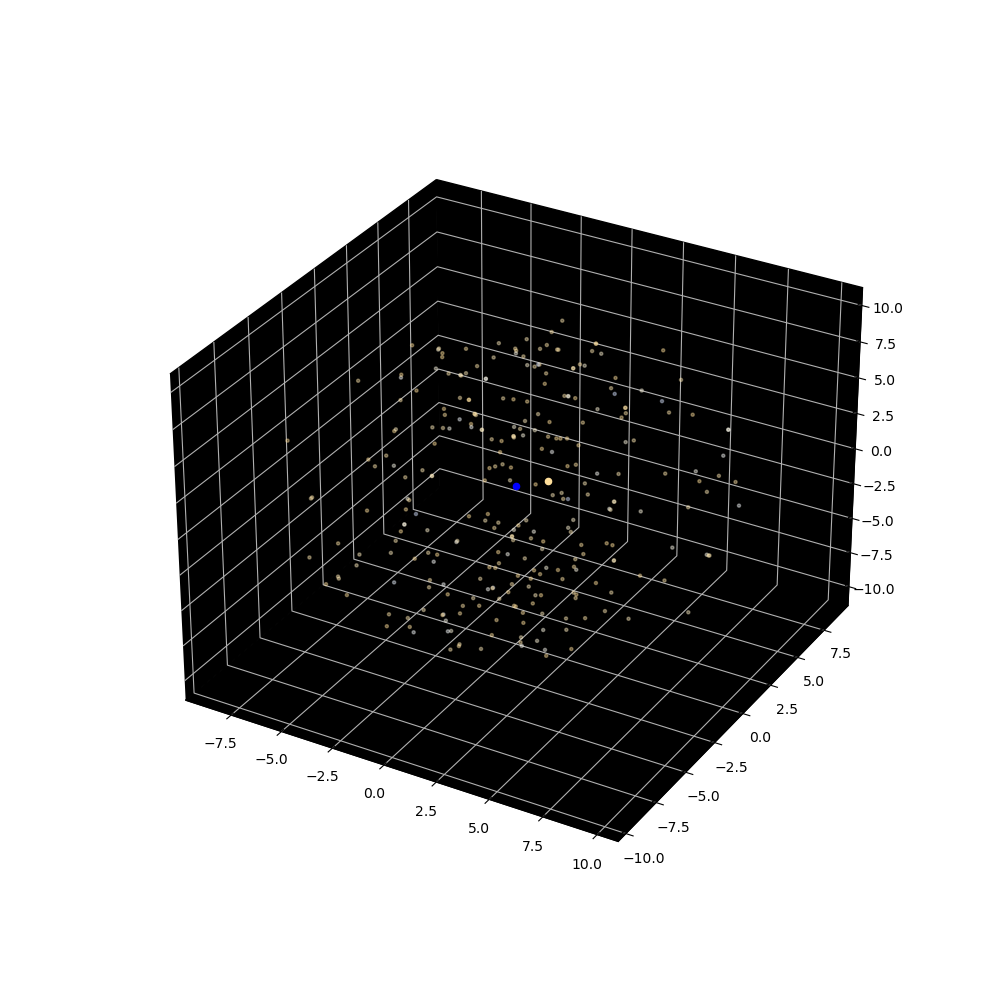

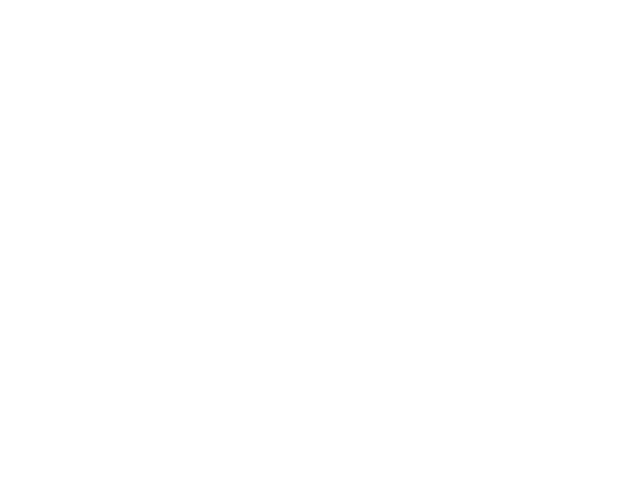

In [2]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import defaultdict
import math as mat
from matplotlib import cm
import scipy as sp
from astropy.cosmology import FlatLambdaCDM,WMAP5,WMAP7,WMAP9,Planck13,Planck15
from astropy import units as u
from astropy.units import cds
import matplotlib.pyplot as plt
import astropy.constants as cc
from scipy.special import zeta
from scipy.optimize import newton
from scipy.integrate import simps
from numpy import sqrt,pi,exp

colums = ['source_id','ra','dec','PLX','T']

data = pd.read_csv('1673642118120O-result.csv', skiprows=1 ,names= colums)

Distance_table = abs(1/(data['PLX'] * 0.001))
ra_dat = list(data['ra'])
dec_dat = list(data['dec'])
x = Distance_table * np.cos(data['ra']) * np.sin(data['dec'])
y = Distance_table * np.sin(data['ra']) * np.sin(data['dec'])
z = Distance_table * np.cos(data['dec'])

Wavelength = 0.0029/(data["T"]) * 10**9


def rgb(lam,spec,std=False,ncol=1,showit=False):
    """
    Return RGB color of a spectrum.
    Keywords
    --------
    lam:        Wavelength in nm
    spec:       Radiance, or intensity, or brightness, or luminosity, or
                whatever quantity with units that are sorta kinda
                energy/s/sterad/cm2/wavelength. Normalization doesn't matter.
    ncol:       Normalization constant, e.g. set ncol=255 for color range [0-255]
    """
    x,y = xy(lam,spec)
    z   = 1 - x - y
    Y   = 1.
    X   = (Y/y) * x
    Z   = (Y/y) * z
    XYZ = np.array([X,Y,Z])

    # Matrix for Wide RGB D65 conversion
    if std:
        XYZ2RGB = np.array([[ 3.2406, -1.5372, -0.4986],
                            [-0.9689,  1.8758,  0.0415],
                            [ 0.0557, -0.2040,  1.0570]])
    else:
        XYZ2RGB = np.array([[ 1.656492, -0.354851, -0.255038],
                            [-0.707196,  1.655397,  0.036152],
                            [ 0.051713, -0.121364,  1.011530]])

    RGB = np.dot(XYZ2RGB,XYZ)                   #Map XYZ to RGB
    RGB = adjust_gamma(RGB)                     #Adjust gamma
  # RGB = RGB / np.array([0.9505, 1., 1.0890])  #Scale so that Y of "white" (D65) is (0.9505, 1.0000, 1.0890)
    maxRGB = max(RGB.flatten())
    if maxRGB > 1: RGB = RGB / maxRGB           #Normalize to 1 if there are values above
    RGB = RGB.clip(min=0)                       #Clip negative values

    if showit:
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches
        plt.close('all')
        fig,ax = plt.subplots(figsize=plt.figaspect(1))
      # wm = plt.get_current_fig_manager()
      # wm.window.wm_geometry('100x100+700+550')
        ax.set_xticks([])
        ax.set_xticklabels('')
        ax.set_yticks([])
        ax.set_yticklabels('')
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        rgba = [RGB[0], RGB[1], RGB[2], 1.]
        rect = patches.Rectangle((0,0),1,1, edgecolor='none',facecolor=rgba)
        ax.add_patch(rect)
        plt.tight_layout()
        plt.draw()
        plt.show()
        input("Hit Enter to quit")
        plt.close()


    RGB = ncol * RGB                            #Normalize to number of colors

    return RGB

def xy(lam,L):
    """
    Return x,y position in CIE 1931 color space chromaticity diagram for an
    arbitrary spectrum.
    Keywords
    -------
    lam:    Wavelength in nm
    L:      Spectral radiance
    """
    lamcie,xbar,ybar,zbar = cie()               #Color matching functions
    L = np.interp(lamcie,lam,L)                 #Interpolate to same axis

    #Tristimulus values
    X = simps(L*xbar,lamcie)
    Y = simps(L*ybar,lamcie)
    Z = simps(L*zbar,lamcie)
    XYZ = np.array([X,Y,Z])
    x = X / sum(XYZ)
    y = Y / sum(XYZ)
    z = Z / sum(XYZ)
    return x,y

def planck(lam, T):
    """
    Spectral radiance of a blackbody of temperature T.
    Keywords
    -------
    lam     Wavelength in nm
    T       Temperature in K
    Returns
    -------
    Spectral radiance in cgs units (erg/s/sr/cm2)
    """
    lam = lam * u.nm
    x   = cc.h * cc.c / lam / cc.k_B / (T*u.K)
    B   = 2*cc.h*cc.c**2 / lam**5 / (exp(x) - 1)
    return B.cgs.value

def rgb_from_T(T,std=False,ncol=1,showit=False):
    """
    Calculate RGB color of a Planck spectrum of temperature T.
    See rgb.__doc__ for a description of keywords.
    """
    lam = np.linspace(350,800,100)
    B   = planck(lam,T)

    if showit:
        RGB = rgb(lam,B,std=std,ncol=1,showit=True)
    else:
        if T < 670:
            RGB = np.array([1,0,0])
        elif 670 <= T < 675:
            RGB = rgb(lam,B,std=std,ncol=1,showit=False)
            RGB[2] = 0
        elif 675 <= T < 1e7:
            RGB = rgb(lam,B,std=std,ncol=1,showit=False)
        else:
            RGB = np.array([0.63130101, 0.71233531, 1.])

    return ncol * RGB

def cie():
    """
    Color matching functions. Columns are wavelength in nm, and xbar, ybar,
    and zbar, are the functions for R, G, and B, respectively.
    """
    lxyz = np.array([[380., 0.0014, 0.0000, 0.0065],
                     [385., 0.0022, 0.0001, 0.0105],
                     [390., 0.0042, 0.0001, 0.0201],
                     [395., 0.0076, 0.0002, 0.0362],
                     [400., 0.0143, 0.0004, 0.0679],
                     [405., 0.0232, 0.0006, 0.1102],
                     [410., 0.0435, 0.0012, 0.2074],
                     [415., 0.0776, 0.0022, 0.3713],
                     [420., 0.1344, 0.0040, 0.6456],
                     [425., 0.2148, 0.0073, 1.0391],
                     [430., 0.2839, 0.0116, 1.3856],
                     [435., 0.3285, 0.0168, 1.6230],
                     [440., 0.3483, 0.0230, 1.7471],
                     [445., 0.3481, 0.0298, 1.7826],
                     [450., 0.3362, 0.0380, 1.7721],
                     [455., 0.3187, 0.0480, 1.7441],
                     [460., 0.2908, 0.0600, 1.6692],
                     [465., 0.2511, 0.0739, 1.5281],
                     [470., 0.1954, 0.0910, 1.2876],
                     [475., 0.1421, 0.1126, 1.0419],
                     [480., 0.0956, 0.1390, 0.8130],
                     [485., 0.0580, 0.1693, 0.6162],
                     [490., 0.0320, 0.2080, 0.4652],
                     [495., 0.0147, 0.2586, 0.3533],
                     [500., 0.0049, 0.3230, 0.2720],
                     [505., 0.0024, 0.4073, 0.2123],
                     [510., 0.0093, 0.5030, 0.1582],
                     [515., 0.0291, 0.6082, 0.1117],
                     [520., 0.0633, 0.7100, 0.0782],
                     [525., 0.1096, 0.7932, 0.0573],
                     [530., 0.1655, 0.8620, 0.0422],
                     [535., 0.2257, 0.9149, 0.0298],
                     [540., 0.2904, 0.9540, 0.0203],
                     [545., 0.3597, 0.9803, 0.0134],
                     [550., 0.4334, 0.9950, 0.0087],
                     [555., 0.5121, 1.0000, 0.0057],
                     [560., 0.5945, 0.9950, 0.0039],
                     [565., 0.6784, 0.9786, 0.0027],
                     [570., 0.7621, 0.9520, 0.0021],
                     [575., 0.8425, 0.9154, 0.0018],
                     [580., 0.9163, 0.8700, 0.0017],
                     [585., 0.9786, 0.8163, 0.0014],
                     [590., 1.0263, 0.7570, 0.0011],
                     [595., 1.0567, 0.6949, 0.0010],
                     [600., 1.0622, 0.6310, 0.0008],
                     [605., 1.0456, 0.5668, 0.0006],
                     [610., 1.0026, 0.5030, 0.0003],
                     [615., 0.9384, 0.4412, 0.0002],
                     [620., 0.8544, 0.3810, 0.0002],
                     [625., 0.7514, 0.3210, 0.0001],
                     [630., 0.6424, 0.2650, 0.0000],
                     [635., 0.5419, 0.2170, 0.0000],
                     [640., 0.4479, 0.1750, 0.0000],
                     [645., 0.3608, 0.1382, 0.0000],
                     [650., 0.2835, 0.1070, 0.0000],
                     [655., 0.2187, 0.0816, 0.0000],
                     [660., 0.1649, 0.0610, 0.0000],
                     [665., 0.1212, 0.0446, 0.0000],
                     [670., 0.0874, 0.0320, 0.0000],
                     [675., 0.0636, 0.0232, 0.0000],
                     [680., 0.0468, 0.0170, 0.0000],
                     [685., 0.0329, 0.0119, 0.0000],
                     [690., 0.0227, 0.0082, 0.0000],
                     [695., 0.0158, 0.0057, 0.0000],
                     [700., 0.0114, 0.0041, 0.0000],
                     [705., 0.0081, 0.0029, 0.0000],
                     [710., 0.0058, 0.0021, 0.0000],
                     [715., 0.0041, 0.0015, 0.0000],
                     [720., 0.0029, 0.0010, 0.0000],
                     [725., 0.0020, 0.0007, 0.0000],
                     [730., 0.0014, 0.0005, 0.0000],
                     [735., 0.0010, 0.0004, 0.0000],
                     [740., 0.0007, 0.0002, 0.0000],
                     [745., 0.0005, 0.0002, 0.0000],
                     [750., 0.0003, 0.0001, 0.0000],
                     [755., 0.0002, 0.0001, 0.0000],
                     [760., 0.0002, 0.0001, 0.0000],
                     [765., 0.0001, 0.0000, 0.0000],
                     [770., 0.0001, 0.0000, 0.0000],
                     [775., 0.0001, 0.0000, 0.0000],
                     [780., 0.0000, 0.0000, 0.0000]])
    return lxyz.T
def adjust_gamma(RGB):
    """
    Adjust gamma value of RGB color
    """
    a = 0.055
    for i,color in enumerate(RGB):
        if color <= 0.0031308:
            RGB[i] = 12.92 * color
        else:
            RGB[i] = (1+a) * color**(1/2.4) - a
    return RGB

RGBA = []
for Temp in data["T"]:
    RGBA.append(rgb_from_T(Temp))
print(data['source_id'])

user_input= input("Which star would you like to highlight ('None' for no highlight) please enter the source id:")

user_input_int = int(user_input)
Source_id = list(data['source_id'])
for data in Source_id:
    if data == int(user_input) :
        Correct = 1 
        Name = Source_id.index(user_input_int)

        break
    else :
        Correct = 0 

        
if user_input == 'None':

    fig = plt.figure()
    plt.figure(figsize=(10,10))
    plt.style.context('dark_background')
    ax = plt.axes(projection='3d')
    ax.scatter3D(x, y, z, c=RGBA, alpha=0.4, marker='.')
    ax.w_xaxis.set_pane_color((0, 0, 0, 1.0)) 
    ax.w_yaxis.set_pane_color((0, 0, 0, 1.0)) 
    ax.w_zaxis.set_pane_color((0, 0, 0, 1.0)) 
    ax.scatter3D(0, 0, 0, c='Blue', alpha=1)
    
elif Correct == 1 :

    fig = plt.figure()
    plt.figure(figsize=(10,10))
    plt.style.context('dark_background')
    ax = plt.axes(projection='3d')
    ax.scatter3D(x, y, z, c=RGBA, alpha=0.4, marker= '.')
    ax.scatter3D(x[Name], y[Name], z[Name], color =RGBA[Name], alpha=1, marker= 'o')
    ax.w_xaxis.set_pane_color((0, 0, 0, 1.0)) 
    ax.w_yaxis.set_pane_color((0, 0, 0, 1.0)) 
    ax.w_zaxis.set_pane_color((0, 0, 0, 1.0)) 
    ax.scatter3D(0, 0, 0, c='Blue', alpha=1)
    print("This is star ",user_input,"This star has coordinates Ra:", str(ra_dat[Name]) , "Dec:", str(dec_dat[Name]) ,"\
    and Distance:", Distance_table[Name] ,'pc' )
    


elif Correct == 0 :
    fig = plt.figure()
    plt.figure(figsize=(10,10))
    plt.style.context('dark_background')
    ax = plt.axes(projection='3d')
    ax.scatter3D(x, y, z, c=RGBA, alpha=0.4, marker='.')
    ax.w_xaxis.set_pane_color((0, 0, 0, 1.0)) 
    ax.w_yaxis.set_pane_color((0, 0, 0, 1.0)) 
    ax.w_zaxis.set_pane_color((0, 0, 0, 1.0)) 
    ax.scatter3D(0, 0, 0, c='Blue', alpha=1)
    



plt.show()



In [ ]:
# \Region = NGC2301
# \Field = Center
# \StarID = NGC2301_Center_4
# \RA = 102.962862
# \Dec = +0.427582
# \Bmag = 11.976
# \Berr = 0.001
# \Rmag = 11.460
# \Rerr = 0.003
# \LCfil = R
# \Npts = 167
# \StartHJD = 2453047.75603932
# \EndHJD = 2453058.93688475
# \BaseHJD = 2453047
# \LCdisp = 0.006
# \LCchisq = 9.19
# \N5sig = 0
# \F5sig = 0.000
# \Duplicate1 = null
# \Duplicate2 = null
# \Public = Y
# \Reference1 = Tonry, et al. 2005, PASP, 117, 281
# \Reference2 = Howell et al. 2005, PASP, 117, 1187
# \ Keywords required by LightCurveViewer
# \Time_Type = HJD
# \Time_Units = days
# \Value_Type = Rmag
# \Value_Units = mag
# \ErrorValue_Type = eRmag
# \ErrorValue_Units = mag
# \Beginning_Value = 11.4768
# \Ending_Value = 11.4482

In [ ]:
# import argparse
# import numpy as np
# from numpy import sqrt,pi,exp
# import scipy as sp
# from astropy.cosmology import FlatLambdaCDM,WMAP5,WMAP7,WMAP9,Planck13,Planck15
# from astropy import units as u
# from astropy.units import cds
# import matplotlib.pyplot as plt
# import astropy.constants as cc
# from scipy.special import zeta
# from scipy.optimize import newton
# from scipy.integrate import simps
# mycosmo = FlatLambdaCDM(H0       = 67.81,
#                         Om0      = 0.308,
#                         Ob0      = .0484,
#                       # Onu0     = 3.710122469245305e-05,
#                       # Ogamma0  = 5.373825182529615e-05,
#                         name     ='My cosmology')

# def uniProp(t,                  #Time with unit
#             cosmo  = Planck15,  #Cosmology, astropy-style
#             Runit  = u.m,       #Unit to display size of Universe in
#             output = False,     #Output Evernote string
#             showit = False
#             ):
#     """
#     Purpose:
#         Calculate properties of the Universe at time t.
#     History:
#         The code was written in conjunction with the (Danish) popular science
#         article "Big Bang --- en oejenvidneberetning" ("Big Bang --- an
#         eyewitness account"), in order to calculate various properties of the
#         Universe. It is meant for being run from the command line, since this
#         is more tractable to non-experts, but can also be run from a Python
#         environment is a slightly different way.
#     Usage:
#         From the command line:
#             > python timeline.py time unit [-Runit my_dist_unit]
#         From Python environment:
#             >>> from astropy import units as u
#             >>> import timeline
#             >>> timeline.uniProp(t=time*unit [,Runit=my_dist_unit])
#     Arguments (for command line):
#         time    Time quantity, i.e. a number
#         unit    Unit of time. Allowed values are
#                   s:   Seconds
#                   min: Minutes
#                   h:   Hours
#                   day: Days
#                   yr:  Years
#                   kyr: Thousand years
#                   Myr: Million years
#                   Gyr: Billion years
#     Optional arguments:
#         -Runit my_dist_unit  Sensible units for distances are estimated. If you
#                              want other units, give the "-Runit" keyword,
#                              followed by your desired units, which can be any
#                              astropy unit, e.g. angstrom, km, Gpc.
#         -cosmo my_cosmology  Set of cosmological parameters, astropy style.
#                              Allowed cosmologies are WMAP5, WMAP7, WMAP9,
#                              Planck13, and Planck15 (default)
#     Examples:
#         > python timeline.py 1e-32 s            # Properties just after inflation
#         > python timeline.py 13.79 Gyr          # Properties today
#         > python timeline.py 500 Myr -Runit Gpc # Properties 500 million years after
#                                                 # Big Bang, but use Gpc (giga-parsec)
#                                                 # for distances
#     Same examples from Python environment:
#         >>> from astropy import units as u
#         >>> import timeline
#         >>> timeline.uniProp(1e-32*u.s)
#         >>> timeline.uniProp(13.79*u.Gyr)
#         >>> timeline.uniProp(500*u.Myr, Runit=u.Gpc)
#     """


#     def photonPressure(T):
#         """Photon pressure"""
#         return (pi**2 * cc.k_B**4 / (45 * cc.c**3 * cc.h**3) * T**4)


#     def nph(T):
#         """Photon number density"""
#         return 16 * pi * (cc.k_B*T / (cc.h*cc.c))**3 * zeta(3)

#     # Calculate radiation-matter equality
#     assert (isinstance(t,u.Quantity)) and (t.unit.is_equivalent(u.s)), '\n\nKeyword `t` must have units of time.'
#     assert t >= 1e-32*u.s,    '\n\nt must be >= the end of inflation, which is assumed to be at 1e-32 s.'
#     assert t <= cosmo.age(0), "\n\nt must be <= the age of the Universe, which for the chosen cosmology is {:}".format(cosmo.age(0))
#     a_eq = newton(a_eqSolver,3400.,args=(cosmo,))
#     z_eq = 1/a_eq - 1
#     t_eq = cosmo.age(z_eq).to(u.yr) # (4/3. * (1 - 1/sqrt(2)) * (cosmo.Onu0 + cosmo.Ogamma0)**1.5/cosmo.Om0**2 / cosmo.H0).to(u.yr)
#     rho_eq = cosmo.critical_density(z_eq)

#     # Calculate matter-dark energy equality
#     a_DE = (cosmo.Om0 / cosmo.Ode0)**.3333333
#     z_DE = 1/a_DE - 1
#     t_DE = cosmo.age(z_DE).to(u.Gyr)

#     # Calculate redshift, density, and temperature
#     if t <= t_eq:
#         epoch = 'photon epoch'
#         a   = (a_eq * sqrt(t/t_eq).decompose()).value
#         rho = rho_eq * (a_eq/a)**4
#         z   = 1./a - 1
#         T   = cosmo.Tcmb0 / a
#     else:
#         epoch = 'matter epoch' if t<t_DE else 'dark energy epoch'
#         from astropy.cosmology import z_at_value
#         z   = z_at_value(cosmo.age, t, zmin=0, zmax=5000)
#         a   = cosmo.scale_factor(z)
#         rho = cosmo.critical_density(z)
#         T   = cosmo.Tcmb(z)

#     # More properties
#     H    = cosmo.H(z)                       #Hubble parameter
#     R0   = cosmo.comoving_distance(2.7e7)   #Distance in cm to particle horizon today; the 2.7e7 is roughly the highest redshift it can take, but using 1e7, or even 1e6 or 1e4 gives almost the same result
#     d_hor = dP(z,cosmo)                     # Horizon distance at t
#     d_H   = cc.c / H                        # Hubble radius at t
#     Pph  = photonPressure(T)                #Photon pressure
#     R    = a * R0                           #Radius of Universe at end of inflation
#     rhob = cosmo.critical_density0 * cosmo.Ob0 / a**3   #Baryon density at t
#     n_ph = nph(T)                           #Photon number desity 
#     X    = .75                              #Primordial hydrogen mass fraction
#     Y    = 1 - X                            #Primordial helium
#     mu   = 1 / (X + Y/4)                    #Mean molecular mass per ion
#     nbar = rhob / (mu*cc.m_p)               #Number density of baryons
#     Pbar = nbar * cc.k_B * T                #Baryon pressure
#     RGB  = rgb_from_T(T/u.K, ncol=255)      #RGB color code
#     E    = cc.k_B * T                       #Energy per particle

#     # Calculate ionization fraction and resulting mean free path of photons
#     if T > 4500*u.K:
#         xe = 1.
#     elif 4500*u.K >= T > 500*u.K:
#         if T > 2500*u.K:
#             x0 = .999
#         elif 2500*u.K >= T > 100*u.K:
#             x0 = .5
#         elif 100*u.K >= T > 50*u.K:
#             x0 = 1e-5
#         xe  = newton(Saha,x0,args=(T.value,cosmo))
#     elif T <= 500*u.K:
#         xe = 1e-10
#     mfp   = meanFreePath(rhob,xe,X)

#     # Print results
#     u.c = 2.99792458e10 * u.cm / u.s
#   # c = u.def_unit('c', 2.99792458e10 * u.cm / u.s)
#     print('Cosmology: ', cosmo)
#     print('Redshift and age at radiation-matter equality:   {:.0f} {:.0f}'.format(z_eq, (t_eq).to(u.yr)))
#     print('Redshift and age at matter-dark energy equality: {:.2f} {:.2f}'.format(z_DE, (t_DE).to(u.Gyr)))
#     print('Radius of Universe today:                        {:2.2f}'.format(R0.to(u.Glyr)))
#     print()
#     print('Physical properties at t = {:}'.format(t) + ' ('+epoch+'):')
#     print(' * Expansion:')
#     print('   - Scale factor:                         {:.3g}'.format(a))
#     print('   - Redshift:                             {:.4g}'.format(z))
#     print('   - Hubble parameter:                     {:.3g}'.format(H))
#  #  print('     - H(t) in c / m:                      {:.3g}'.format(H.to(u.c/u.m).value))
#  #  print('   - e-foldings since t:                   {:2.1f}'.format(np.log(1/a)))
#     print(' * Size:')
#     print('   - Radius of observable Universe at t:   {:.3g}'.format(d_hor.to(Runit)))
#     print("   - Radius of today's obs. Universe at t: {:.3g}".format(R.to(Runit)))
#     print('   - Hubble distance:                      {:.3g}'.format(d_H.to(Runit)))
#     print(' * Gas and radiation:')
#     print('   - Temperature:                          {:.1e}'.format(T))
#     print('   - RGB color:                            {:.1f}, {:.1f}, {:.1f}'.format(*RGB))
#     print('   - Energy:                               {:.3g}'.format(E.to(u.MeV)))
#     print('   - Energy density:                       {:.3g}'.format(rho))
#     print('   - Ionized fraction:                     {:.3g}'.format(xe))
#     print('   - Photon mean free path:                {:.3g}'.format(mfp.to(Runit)))
#     print('     - mfp / d_H                           {:.3g}'.format((mfp / d_H).decompose()))
#     print('   - Photon no. density:                   {:.3g}'.format(n_ph.to(u.cm**(-3))))
#     print('   - Baryon no. density:                   {:.3g}'.format(nbar.to(u.cm**(-3))))
#     print('   - Photon pressure:                      {:.3g}'.format(Pph.to(u.cds.atm)))
#     print('   - Baryon pressure:                      {:.3g}'.format(Pbar.to(u.cds.atm)))

#     # Print one-lines (for timeline table)
#     if output:
#         numbers = [t,
#                    T,
#                    E.to(u.eV),
#                    d_hor.to(u.Mpc),
#                    R.to(u.Mpc),
#                    H.to(u.km/u.s/u.Mpc),
#                    rho,
#                    a,
#                    z,
#                    n_ph.to(u.cm**(-3)),
#                    mfp.to(u.Gpc),
#                    Pph.to(u.cds.atm)]
#         print('              {:.3g}     {:.3g}                {:.3g}  {:.3g} {:.3g}  {:.3g}  {:.3g}                                     {:.3g}   {:.3g}   {:.3g}      {:.3g}    {:.3g}'.format(*numbers))

#     if showit:
#         dummy = rgb_from_T(T/u.K, ncol=255, showit=True)



# def mue(X):
#     """Mean molecular mass per electron"""
#     return 2. / (1+X)


# def ne(rhob,xe,X):
#     """Number density of electrons"""
#     return xe * rhob / (mue(X)*cc.m_p)


# def meanFreePath(rhob,xe,X):
#     """Mean free path to Thomson scattering"""
#     return 1 / (ne(rhob,xe,X) * cc.sigma_T)


# def Saha(xe,T,cosmo):
#     """Saha equation solver"""
#     return xe**2/(1-xe) - 5.8e15/(cosmo.Ob0*cosmo.h**2*(T/1e4)**1.5) * exp(-157000/T)


# def dP(z,cosmo):
#     """
#     Particle horizon
#     """
#     from astropy.cosmology import z_at_value

#   # a_eq = (cosmo.Onu0 + cosmo.Ogamma0) / cosmo.Om0
#     a_eq = newton(a_eqSolver,3400.,args=(cosmo,))
#     z_eq = 1/a_eq - 1
#     t_eq = cosmo.age(z_eq).to(u.s).value

#     def inva(t):
#         if t <= t_eq:
#           # a = sqrt(2 * sqrt(cosmo.Onu0+cosmo.Ogamma0) * (cosmo.H0 * t).decompose()).value
#             a = a_eq * sqrt(t/t_eq)
#         else:
#             z = z_at_value(cosmo.age, t*u.s, zmax=1e4)
#             a = cosmo.scale_factor(z)
#         return 1 / a

#     eta,err = sp.integrate.quad(inva,0,cosmo.age(z).to(u.s).value) * u.s

#     return cc.c * eta / (1+z)


# def a_eqSolver(a,cosmo):
#     z   = 1./a - 1
#     Og0 = cosmo.Ogamma0
#     Om0 = cosmo.Om0
#     fa  = cosmo.nu_relative_density(z)
#     return (1+fa) * Og0/Om0 - a


# def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('time',                         type=float, help='Time quantity')
#     parser.add_argument('unit',                         type=str,   help='Time unit (s,min,day,yr,kyr,Myr,Gyr)')
#     parser.add_argument('-Runit',   default='',         type=str,   help='Unit for distances (not exactly sure why this works)')
#     parser.add_argument('-cosmo',   default='Planck15', type=str,   help='Cosmology (WMAP5, WMAP7, WMAP9, Planck13, Planck15). Default is Planck15')
#     parser.add_argument('-showcol', action='store_true',            help='Show color in separate window')
#     args = parser.parse_args()

#     # Set time unit
#     if args.unit == 's':
#         time  = args.time * u.s
#         Runit = u.cm
#     elif args.unit == 'min':
#         time  = args.time * u.min
#         Runit = u.AU
#     elif args.unit == 'day':
#         time  = args.time * u.day
#         Runit = u.lyr
#     elif args.unit == 'yr':
#         time  = args.time * u.yr
#         Runit = u.lyr
#     elif args.unit == 'kyr':
#         time  = args.time * u.kyr
#         Runit = u.Mlyr
#     elif args.unit == 'Myr':
#         time  = args.time * u.Myr
#         Runit = u.Mlyr
#     elif args.unit == 'Gyr':
#         time  = args.time * u.Gyr
#         Runit = u.Glyr
#     else:
#         print("Sorry, unit `"+args.unit+"` is not implemented.\nYou're welcome to go ahead and do it yourself,\nand then send me a pull request.")
#         exit()

#     # Set distance unit
#     if args.Runit != '':
#         Runit = args.Runit

#     #Set cosmology
#     if args.cosmo == 'WMAP5':
#         cosmo = WMAP5
#     elif args.cosmo == 'WMAP7':
#         cosmo = WMAP7
#     elif args.cosmo == 'WMAP9':
#         cosmo = WMAP9
#     elif args.cosmo == 'Planck13':
#         cosmo = Planck13
#     elif args.cosmo == 'Planck15':
#         cosmo = Planck15
#     else:
#         print("Sorry, cosmology `"+args.cosmo+"` is not implemented.\nYou're welcome to go ahead and do it yourself,\nand then send me a pull request.")
#         exit()

#     # Calculate it!
#     uniProp(t=time, Runit=Runit, cosmo=cosmo, showit=args.showcol)


# def planck(lam, T):
#     """
#     Spectral radiance of a blackbody of temperature T.
#     Keywords
#     -------
#     lam     Wavelength in nm
#     T       Temperature in K
#     Returns
#     -------
#     Spectral radiance in cgs units (erg/s/sr/cm2)
#     """
#     lam = lam * u.nm
#     x   = cc.h * cc.c / lam / cc.k_B / (T*u.K)
#     B   = 2*cc.h*cc.c**2 / lam**5 / (exp(x) - 1)
#     return B.cgs.value


# def rgb_from_T(T,std=False,ncol=1,showit=False):
#     """
#     Calculate RGB color of a Planck spectrum of temperature T.
#     See rgb.__doc__ for a description of keywords.
#     """
#     lam = np.linspace(350,800,100)
#     B   = planck(lam,T)

#     if showit:
#         RGB = rgb(lam,B,std=std,ncol=1,showit=True)
#     else:
#         if T < 670:
#             RGB = np.array([1,0,0])
#         elif 670 <= T < 675:
#             RGB = rgb(lam,B,std=std,ncol=1,showit=False)
#             RGB[2] = 0
#         elif 675 <= T < 1e7:
#             RGB = rgb(lam,B,std=std,ncol=1,showit=False)
#         else:
#             RGB = np.array([0.63130101, 0.71233531, 1.])

#     return ncol * RGB


# def rgb(lam,spec,std=False,ncol=1,showit=False):
#     """
#     Return RGB color of a spectrum.
#     Keywords
#     --------
#     lam:        Wavelength in nm
#     spec:       Radiance, or intensity, or brightness, or luminosity, or
#                 whatever quantity with units that are sorta kinda
#                 energy/s/sterad/cm2/wavelength. Normalization doesn't matter.
#     ncol:       Normalization constant, e.g. set ncol=255 for color range [0-255]
#     """
#     x,y = xy(lam,spec)
#     z   = 1 - x - y
#     Y   = 1.
#     X   = (Y/y) * x
#     Z   = (Y/y) * z
#     XYZ = np.array([X,Y,Z])

#     # Matrix for Wide RGB D65 conversion
#     if std:
#         XYZ2RGB = np.array([[ 3.2406, -1.5372, -0.4986],
#                             [-0.9689,  1.8758,  0.0415],
#                             [ 0.0557, -0.2040,  1.0570]])
#     else:
#         XYZ2RGB = np.array([[ 1.656492, -0.354851, -0.255038],
#                             [-0.707196,  1.655397,  0.036152],
#                             [ 0.051713, -0.121364,  1.011530]])

#     RGB = np.dot(XYZ2RGB,XYZ)                   #Map XYZ to RGB
#     RGB = adjust_gamma(RGB)                     #Adjust gamma
#   # RGB = RGB / np.array([0.9505, 1., 1.0890])  #Scale so that Y of "white" (D65) is (0.9505, 1.0000, 1.0890)
#     maxRGB = max(RGB.flatten())
#     if maxRGB > 1: RGB = RGB / maxRGB           #Normalize to 1 if there are values above
#     RGB = RGB.clip(min=0)                       #Clip negative values

#     if showit:
#         import matplotlib.pyplot as plt
#         import matplotlib.patches as patches
#         plt.close('all')
#         fig,ax = plt.subplots(figsize=plt.figaspect(1))
#       # wm = plt.get_current_fig_manager()
#       # wm.window.wm_geometry('100x100+700+550')
#         ax.set_xticks([])
#         ax.set_xticklabels('')
#         ax.set_yticks([])
#         ax.set_yticklabels('')
#         ax.set_xlim([0,1])
#         ax.set_ylim([0,1])
#         rgba = [RGB[0], RGB[1], RGB[2], 1.]
#         rect = patches.Rectangle((0,0),1,1, edgecolor='none',facecolor=rgba)
#         ax.add_patch(rect)
#         plt.tight_layout()
#         plt.draw()
#         plt.show()
#         input("Hit Enter to quit")
#         plt.close()


#     RGB = ncol * RGB                            #Normalize to number of colors

#     return RGB


# def xy(lam,L):
#     """
#     Return x,y position in CIE 1931 color space chromaticity diagram for an
#     arbitrary spectrum.
#     Keywords
#     -------
#     lam:    Wavelength in nm
#     L:      Spectral radiance
#     """
#     lamcie,xbar,ybar,zbar = cie()               #Color matching functions
#     L = np.interp(lamcie,lam,L)                 #Interpolate to same axis

#     #Tristimulus values
#     X = simps(L*xbar,lamcie)
#     Y = simps(L*ybar,lamcie)
#     Z = simps(L*zbar,lamcie)
#     XYZ = np.array([X,Y,Z])
#     x = X / sum(XYZ)
#     y = Y / sum(XYZ)
#     z = Z / sum(XYZ)
#     return x,y


# def cie():
#     """
#     Color matching functions. Columns are wavelength in nm, and xbar, ybar,
#     and zbar, are the functions for R, G, and B, respectively.
#     """
#     lxyz = np.array([[380., 0.0014, 0.0000, 0.0065],
#                      [385., 0.0022, 0.0001, 0.0105],
#                      [390., 0.0042, 0.0001, 0.0201],
#                      [395., 0.0076, 0.0002, 0.0362],
#                      [400., 0.0143, 0.0004, 0.0679],
#                      [405., 0.0232, 0.0006, 0.1102],
#                      [410., 0.0435, 0.0012, 0.2074],
#                      [415., 0.0776, 0.0022, 0.3713],
#                      [420., 0.1344, 0.0040, 0.6456],
#                      [425., 0.2148, 0.0073, 1.0391],
#                      [430., 0.2839, 0.0116, 1.3856],
#                      [435., 0.3285, 0.0168, 1.6230],
#                      [440., 0.3483, 0.0230, 1.7471],
#                      [445., 0.3481, 0.0298, 1.7826],
#                      [450., 0.3362, 0.0380, 1.7721],
#                      [455., 0.3187, 0.0480, 1.7441],
#                      [460., 0.2908, 0.0600, 1.6692],
#                      [465., 0.2511, 0.0739, 1.5281],
#                      [470., 0.1954, 0.0910, 1.2876],
#                      [475., 0.1421, 0.1126, 1.0419],
#                      [480., 0.0956, 0.1390, 0.8130],
#                      [485., 0.0580, 0.1693, 0.6162],
#                      [490., 0.0320, 0.2080, 0.4652],
#                      [495., 0.0147, 0.2586, 0.3533],
#                      [500., 0.0049, 0.3230, 0.2720],
#                      [505., 0.0024, 0.4073, 0.2123],
#                      [510., 0.0093, 0.5030, 0.1582],
#                      [515., 0.0291, 0.6082, 0.1117],
#                      [520., 0.0633, 0.7100, 0.0782],
#                      [525., 0.1096, 0.7932, 0.0573],
#                      [530., 0.1655, 0.8620, 0.0422],
#                      [535., 0.2257, 0.9149, 0.0298],
#                      [540., 0.2904, 0.9540, 0.0203],
#                      [545., 0.3597, 0.9803, 0.0134],
#                      [550., 0.4334, 0.9950, 0.0087],
#                      [555., 0.5121, 1.0000, 0.0057],
#                      [560., 0.5945, 0.9950, 0.0039],
#                      [565., 0.6784, 0.9786, 0.0027],
#                      [570., 0.7621, 0.9520, 0.0021],
#                      [575., 0.8425, 0.9154, 0.0018],
#                      [580., 0.9163, 0.8700, 0.0017],
#                      [585., 0.9786, 0.8163, 0.0014],
#                      [590., 1.0263, 0.7570, 0.0011],
#                      [595., 1.0567, 0.6949, 0.0010],
#                      [600., 1.0622, 0.6310, 0.0008],
#                      [605., 1.0456, 0.5668, 0.0006],
#                      [610., 1.0026, 0.5030, 0.0003],
#                      [615., 0.9384, 0.4412, 0.0002],
#                      [620., 0.8544, 0.3810, 0.0002],
#                      [625., 0.7514, 0.3210, 0.0001],
#                      [630., 0.6424, 0.2650, 0.0000],
#                      [635., 0.5419, 0.2170, 0.0000],
#                      [640., 0.4479, 0.1750, 0.0000],
#                      [645., 0.3608, 0.1382, 0.0000],
#                      [650., 0.2835, 0.1070, 0.0000],
#                      [655., 0.2187, 0.0816, 0.0000],
#                      [660., 0.1649, 0.0610, 0.0000],
#                      [665., 0.1212, 0.0446, 0.0000],
#                      [670., 0.0874, 0.0320, 0.0000],
#                      [675., 0.0636, 0.0232, 0.0000],
#                      [680., 0.0468, 0.0170, 0.0000],
#                      [685., 0.0329, 0.0119, 0.0000],
#                      [690., 0.0227, 0.0082, 0.0000],
#                      [695., 0.0158, 0.0057, 0.0000],
#                      [700., 0.0114, 0.0041, 0.0000],
#                      [705., 0.0081, 0.0029, 0.0000],
#                      [710., 0.0058, 0.0021, 0.0000],
#                      [715., 0.0041, 0.0015, 0.0000],
#                      [720., 0.0029, 0.0010, 0.0000],
#                      [725., 0.0020, 0.0007, 0.0000],
#                      [730., 0.0014, 0.0005, 0.0000],
#                      [735., 0.0010, 0.0004, 0.0000],
#                      [740., 0.0007, 0.0002, 0.0000],
#                      [745., 0.0005, 0.0002, 0.0000],
#                      [750., 0.0003, 0.0001, 0.0000],
#                      [755., 0.0002, 0.0001, 0.0000],
#                      [760., 0.0002, 0.0001, 0.0000],
#                      [765., 0.0001, 0.0000, 0.0000],
#                      [770., 0.0001, 0.0000, 0.0000],
#                      [775., 0.0001, 0.0000, 0.0000],
#                      [780., 0.0000, 0.0000, 0.0000]])
#     return lxyz.T


# def adjust_gamma(RGB):
#     """
#     Adjust gamma value of RGB color
#     """
#     a = 0.055
#     for i,color in enumerate(RGB):
#         if color <= 0.0031308:
#             RGB[i] = 12.92 * color
#         else:
#             RGB[i] = (1+a) * color**(1/2.4) - a
#     return RGB

# if __name__ == '__main__':
#     main()

In [ ]:
!pip install ipympl

In [ ]:
import matplotlib.pyplot as plt

# Create some data
x = [1, 2, 3, 4, 5]
y = [10, 8, 6, 4, 2]

# Create a list of markers (e.g. dots, circles, squares) based on another list
# In this example, we use 'o' for even numbered points and '^' for odd numbered points
markers = ['o' if i % 2 == 0 else '^' for i in range(len(x))]

# Plot the data with the variable markers
plt.scatter(x, y, marker = markers)

# Show the plot
plt.show()